In [6]:
import re # for punctuation strip
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from textblob import TextBlob

In [7]:
# Correct the typos on the text summaries

df = pd.read_csv('/Users/irmakergin/Desktop/final-project-irmak-ergin/organized_data/organized_data.csv')

# textblob is not accurate with correcting abbrevations
# and  corrects some words inaccurately so I am exclyding them for now.
# I am dealing with the abbrevations later in the code before I calculate the semantic similarity

exclusion_list = ['ive', 'im', "i've", "i'm",
    "youre", "you're","theyre", "they're", "shes", "she's","hes", "he's",
    "we're", "don't", "dont", "doesn't", "doesnt", "didn't", "didnt", 
                  "sheve", "she've", "he've", "heve", "they've", "theyve", 
                  "weve", "we've", "shouldn't", "shouldnt", "dina","franny",
                  "frannie","isnt", "isn't","aren't", "arent", 'dvd', "wasnt", "wasn't",
                 "werent", "weren't", "limo", "huh", "har", "audition", "phoney","phony", "grilled", "robot",
                 "evertte", "mom", "caller", "memorize", "sheila", 'filming', "tv", "penelope", "bagel",
                 "nanny", "candace","giggle","chunky", "smouldering", "sexy", "levine", "bunny","barney",
                 "pants", "laundry", "kidding"]


# Function to correct words, excluding words start with capital letter and ones defined above

def correct_text(text):
    if pd.isna(text):  # Check if the value is NA
        return text    # Return NA without changes
    
    corrected_words = []
    try:
        for word in str(text).split():
            # Check if the word is not in the exclusion list and doesn't start with a capital letter
            if word.lower() not in exclusion_list and word[0].islower():
                corrected_word = str(TextBlob(word).correct())
            else:
                corrected_word = word
            corrected_words.append(corrected_word)
        corrected_text = ' '.join(corrected_words)
        return corrected_text
    except:
        return text

# Apply the correction function
df['textbox.text_corrected'] = df['textbox.text'].apply(correct_text)

# Find the index of 'textbox.text' column to create the new column 'textbox.text_corrected' for the same trial
text_index = df.columns.get_loc('textbox.text') + 1

# Ceate the new column 'textbox.text_corrected' in the correct position
columns = list(df.columns)
columns = columns[:text_index] + ['textbox.text_corrected'] + [col for col in columns[text_index:] if col != 'textbox.text_corrected']

# Reassign the df's columns using the new order
df = df[columns]

# Save the modified DataFrame to the specified path with the specified file name #CHANGE PATH
df.to_csv('/Users/irmakergin/Desktop/final-project-irmak-ergin/organized_data/organized_file_no_typo.csv', index=False)

In [8]:
# Calculate the semantic similarity of each word in the summaries using GloVe 

filepath = "/Users/irmakergin/Desktop/final-project-irmak-ergin/glove/glove.6B.300d.txt"

word_list = {}
vectors = []
with open(filepath, encoding="utf8") as f:
    i = 0
    for line in f:
        word, *vector = line.split()
        vectors.append(np.array(
                    vector, dtype=np.float32).reshape((1, -1)))
        word_list[word] = i
        i+=1

embedding_matrix = np.concatenate(vectors, axis=0)

In [9]:
def cosine(v1, v2):
    return v1@v2/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [10]:
# correct the abbrevations and turn them into seperate words 
spelling_changes = {
    "frannie": ["franny"],
    "fanny": ["franny"],
    "ive": ["I", "have"],
    "i've": ["I", "have"],
    "im": ["I", "am"],
    "i'm": ["I", "am"],
    "youre": ["you", "are"],
    "you're": ["you", "are"],
    "theyre": ["they", "are"],
    "they're": ["they", "are"],
    "shes": ["she", "is"],
    "she's": ["she", "is"],
    "hes": ["he", "is"],
    "he's": ["he", "is"],
    "we're": ["we", "are"],
    "don't": ["do", "not"],
    "dont": ["do", "not"],
    "doesn't": ["does", "not"],
    "doesnt": ["does", "not"],
    "didn't": ["did", "not"],
    "didnt": ["did", "not"],
    "sheve": ["she", "have"],
    "she've": ["she", "have"],
    "he've": ["he", "have"],
    "heve": ["he", "have"],
    "they've": ["they", "have"],
    "theyve": ["they", "have"],
    "weve": ["we", "have"],
    "we've": ["we", "have"],
    "shouldn't": ["should", "not"],
    "shouldnt": ["should", "not"],
    "isnt": ["is", "not"],
    "isn't": ["is", "not"],
    "aren't": ["are", "not"],
    "arent": ["are", "not"],
    "wasnt": ["was", "not"], 
    "wasn't": ["was", "not"],
    "weren't": ["were", "not"],
    "werent": ["were", "not"]
}

In [11]:
# Load the DataFrame
df = pd.read_csv('/Users/irmakergin/Desktop/final-project-irmak-ergin/organized_data/organized_file_no_typo.csv')

# Create an empty list for similarity matrices
similarity_matrices = []

# Create counters
total_matrices = 0
non_empty_matrices = 0

for index, row in df.iterrows():
    summary = row['textbox.text_corrected']
    stimulus = row['segment_text']
    
    if pd.notna(summary):
        stimulus_words = stimulus.split(' ')
        summary_words = summary.split(' ')
        
        # Initialize a list to accumulate all the words after applying spelling changes
        processed_summary_words = []
        for word in summary_words:
            word = re.sub(r'[^\w\s]', '', word).lower()
            if word in spelling_changes:
                # Extend the list with the expanded form of the word
                processed_summary_words.extend(spelling_changes[word])
            else:
                processed_summary_words.append(word)
        
        # Re-calculate the size of the similarity matrix based on processed summary words
        similarity_matrix = np.zeros([len(stimulus_words), len(processed_summary_words)])
        
        for wi, stim_word in enumerate(stimulus_words):
            stim_word = re.sub(r'[^\w\s]', '', stim_word).lower()
            if stim_word in word_list:
                v_wi = embedding_matrix[word_list[stim_word]]
                for wj, summary_word in enumerate(processed_summary_words):
                    if summary_word in word_list:
                        v_wj = embedding_matrix[word_list[summary_word]]
                        similarity_matrix[wi, wj] = cosine(v_wi, v_wj)
        
        total_matrices += 1
        if np.any(similarity_matrix != 0):
            non_empty_matrices += 1
        similarity_matrices.append(similarity_matrix)

# Sanity check
print(f"Total similarity matrices calculated: {total_matrices}")
print(f"Non-empty similarity matrices: {non_empty_matrices}")



Total similarity matrices calculated: 237
Non-empty similarity matrices: 237


Text(0, 0.5, 'Max Cosine Similarity with Heard Segement')

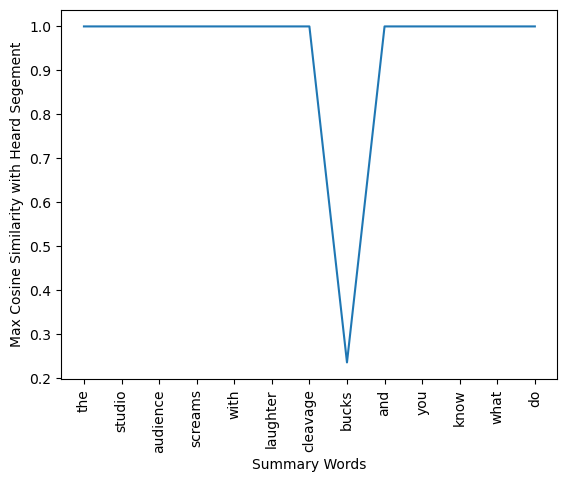

In [12]:
# here is an example from one summary:

plt.plot(summary_words, similarity_matrix.max(0))
plt.xticks(rotation=90)
plt.xlabel("Summary Words")
plt.ylabel("Max Cosine Similarity with Heard Segement")

In [13]:
# take the max value for each word and calculate total similarity score for each summary

# create a list to store the sum of maximum similarity scores for each summary
sum_max_similarities = []

# loop through each similarity matrix to calculate the sum of maximum similarity scores
for similarity_matrix in similarity_matrices:
    # Calculate the max similarity value for each word in the summary (across all stimulus words)
    max_values = np.max(similarity_matrix, axis=0)
    
    # sum these maximum similarity values
    sum_max_similarity = np.sum(max_values) if max_values.size > 0 else 0
    
    # append the sum to the list
    sum_max_similarities.append(sum_max_similarity)

# Sanity check- count the number of successfully calculated sum_max_similarity values
successful_calculations = len(sum_max_similarities) - np.count_nonzero(np.isnan(sum_max_similarities))
print(f"Total number of sum_max_similarity values calculated: {successful_calculations}")
print(len(sum_max_similarities))


Total number of sum_max_similarity values calculated: 237
237
